## Setup

In [737]:
import spacy
import pandas as pd
import json
import matplotlib.pyplot as plt

import random
import typer
from pathlib import Path
from spacy.tokens import DocBin, Doc
from spacy.training.example import Example

# Make the factory work
from rel_pipe import make_relation_extractor, score_relations

# Make the config work
from rel_model import create_relation_model, create_classification_layer, create_instances, create_tensors

# Import custom tokenizer a.o.
import custom_functions

#### Define general Settings

In [738]:
# Paths
plot_path   = "/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/02-Plots/03_results"
ner_path    = "/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/01_ner_model/ner-final-model-trf/model-best"
rel_path    = "/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/rel-final-model-trf/model-best"
test_path   = "/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/test.spacy"
pickle_path = "/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/02-Plots/03_results/data"
# Settings
plt.rcParams["font.family"] = "Times New Roman"

In [739]:
# --> Loading Models
ner = spacy.load(ner_path)
rel = spacy.load(rel_path)

In [740]:
# --> Load test data and name annotated data "golds"
def load_data(test_path=test_path):
    doc_bin = DocBin(store_user_data=True).from_disk(test_path)
    golds = doc_bin.get_docs(rel.vocab)
    return golds

## General Functions

In [741]:
def create_examples(predict_ents=True, print_details=False, predict_rels=True, test_path=test_path):
    """Create a list of Example objects from test data"""
    examples = []
    golds = load_data(test_path)
    for gold in golds:
        # ner prediction
        if predict_ents == True:
            pred = ner(gold.text)
        else:
            pred = Doc(rel.vocab,
                       words=[t.text for t in gold],
                       spaces=[t.whitespace_ for t in gold],)
            pred.ents = gold.ents
            
        # rel prediction
        if predict_rels == True:
            for name, proc in rel.pipeline:
                pred = proc(pred)
        # Create pair of pred and anno & Append pair to list
        examples.append(Example(pred, gold))
    return examples

In [742]:
# predict_ents=True, print_details=False, predict_rels=True
examples = create_examples(False, False, True)

ℹ Detected 156 total instances.
ℹ Detected 35 total instances.
ℹ Detected 180 total instances.
ℹ Detected 37 total instances.
ℹ Detected 220 total instances.
ℹ Detected 101 total instances.
ℹ Detected 95 total instances.
ℹ Detected 158 total instances.
ℹ Detected 173 total instances.
ℹ Detected 127 total instances.
ℹ Detected 59 total instances.
ℹ Detected 126 total instances.
ℹ Detected 29 total instances.
ℹ Detected 161 total instances.
ℹ Detected 113 total instances.
ℹ Detected 89 total instances.
ℹ Detected 70 total instances.
ℹ Detected 115 total instances.
ℹ Detected 198 total instances.
ℹ Detected 155 total instances.
ℹ Detected 193 total instances.
ℹ Detected 154 total instances.
ℹ Detected 107 total instances.
ℹ Detected 101 total instances.
ℹ Detected 87 total instances.
ℹ Detected 164 total instances.
ℹ Detected 164 total instances.
ℹ Detected 108 total instances.
ℹ Detected 78 total instances.
ℹ Detected 129 total instances.
ℹ Detected 135 total instances.
ℹ Detected 115 to

## Overall Score

In [743]:
from spacy.scorer import PRFScore

def score_relations(examples, threshold):
    """Score a batch of examples."""
    micro_prf = PRFScore()
    ec = 0
    c = 0

    for example in examples:
        gold = example.reference._.rel
        pred = example.predicted._.rel
        for key, pred_dict in pred.items():
            try:
                gold_labels = [k for (k, v) in gold[key].items() if v == 1.0]
                for k, v in pred_dict.items():
                    if v >= threshold:
                        if k in gold_labels:
                            micro_prf.tp += 1
                        else:
                            micro_prf.fp += 1
                    else:
                        if k in gold_labels:
                            micro_prf.fn += 1
            except KeyError:
                if max(pred_dict.values()) >= threshold:
                    ec+=1
                    micro_prf.fp += 1
            c+=1                
    return {
        "error_count": ec,
        "rel_count": c,
        "key_error_rate": ec/c,
        "rel_micro_p": micro_prf.precision,
        "rel_micro_r": micro_prf.recall,
        "rel_micro_f": micro_prf.fscore,
    }

In [790]:
thresholds = [n*0.01 for n in range(0,100)]
labels = ['Arg0Z','Arg0Tool','Arg1Z','Arg1Tool','ArgAttr','ArgTemp','ArgDauer','ArgZeitp','ArgPräp']
# labels = ['Arg0Z','Arg0Tool']

In [746]:
# Create a list of (threshold, f1 score) tuples
f_overall_th = []
for th in thresholds:
    f_overall_th.append((th,score_relations(examples, th)["rel_micro_f"]))

In [747]:
# Best overall th
df_f[df_f["f"]==max(df_f["f"])]["th"]

45    0.45
Name: th, dtype: float64

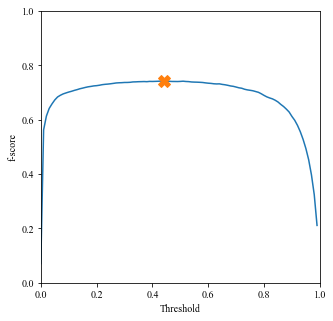

In [816]:
# Plot thresholds over 
df_f = pd.DataFrame(f_overall_th, columns=["th","f"])
best_th = float(df_f[df_f["f"]==max(df_f["f"])]["th"])
plt.figure(figsize=(5,5))
df_f["f"].plot()
plt.plot(best_th*100,df_f["f"][int(best_th*100)], "X", label="Best Threshold", markersize=12)
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,1])
plt.xticks(ticks=[0,20,40,60,80,100], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel('Threshold')
plt.ylabel('f-score')
plt.savefig(plot_path+"/rel_best_th_overall.png")

In [850]:
load_data()
count=0
nlp = ner
#nlp.add_pipe('sentencizer')
for gold in golds:
    for_sents = nlp(gold.text)
    for doc in for_sents.sents:
        count+=1
count

1097

In [749]:
# Evaluate overall model at best threshold
both_eval_overall = pd.DataFrame(score_relations(examples, best_th), index=["measures"])
both_eval_overall.to_pickle(pickle_path+"/rel_eval_overall.pkl")
both_eval_overall

,error_count,rel_count,key_error_rate,rel_micro_p,rel_micro_r,rel_micro_f
measures,0,14370,0.0,0.720326,0.766258,0.742582


In [752]:
labels = ['Arg0Z','Arg0Tool','Arg1Z','Arg1Tool','ArgAttr','ArgTemp','ArgDauer','ArgZeitp','ArgPräp']
def score_relations_ind(examples, threshold, label):
    """Score a batch of examples."""
    load_data()
    ec = 0
    c = 0
    micro_prf = PRFScore()
    for example in examples:
        gold = example.reference._.rel
        pred = example.predicted._.rel
        for key, pred_dict in pred.items():
            try:
                gold_labels = [k for (k, v) in gold[key].items() if v == 1.0]
                for k, v in pred_dict.items():
                    if k == label: # filter only one type of label
                        if v >= threshold:
                            if k in gold_labels:
                                micro_prf.tp += 1
                            else:
                                micro_prf.fp += 1
                        else:
                            if k in gold_labels:
                                micro_prf.fn += 1
            except KeyError: ### was ist mit dem threshold und der max prob?
                if max(pred_dict, key=pred_dict.get) == label:
                    if max(pred_dict.values()) >= threshold:
                        ec+=1
                        micro_prf.fp += 1
            if max(pred_dict, key=pred_dict.get) == label:
                if max(pred_dict.values()) >= threshold:
                    c+=1
    return [label,micro_prf.precision,micro_prf.recall,micro_prf.fscore,micro_prf.tp,micro_prf.fp,micro_prf.fn, ec, c]# , ec/c
    return {
        "label": label,
        "error_count": ec,
        "rel_count": c,
        "key_error_rate": ec/c,
        "rel_micro_p": micro_prf.precision,
        "rel_micro_r": micro_prf.recall,
        "rel_micro_f": micro_prf.fscore,
    }

In [753]:
both_eval_labels = pd.DataFrame([score_relations_ind(examples, best_th, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c"])#, "er"
both_eval_overall.to_pickle(pickle_path+"/rel_eval_labels.pkl")
both_eval_labels

,label,p,r,f,tp,fp,fn,ec,c
0,Arg0Z,0.756222,0.664513,0.707407,1337,431,675,0,1767
1,Arg0Tool,0.689655,0.588235,0.634921,20,9,14,0,29
2,Arg1Z,0.689931,0.908133,0.784135,603,271,61,0,870
3,Arg1Tool,0.809339,0.870293,0.838710,208,49,31,0,256
4,ArgAttr,0.707627,0.757943,0.731921,501,207,160,0,708
5,ArgTemp,0.907692,0.951613,0.929134,59,6,3,0,65
6,ArgDauer,0.851429,0.943038,0.894895,149,26,9,0,175
7,ArgZeitp,0.764192,0.837321,0.799087,175,54,34,0,228
8,ArgPräp,0.618435,0.827834,0.707975,577,356,120,0,933


In [723]:
# Random baseline rel model
rand_bl = pd.DataFrame([
    {"th": 0.00,   "p": 3.66, "r": 100.00, "f": 7.07},
    {"th": 0.05,   "p": 3.66, "r":  95.10, "f": 7.06},
    {"th": 0.10,   "p": 3.65, "r":  89.67, "f": 7.01},
    {"th": 0.20,   "p": 3.65, "r":  79.77, "f": 6.98},
    {"th": 0.30,   "p": 3.65, "r":  69.83, "f": 6.94},
    {"th": 0.40,   "p": 3.61, "r":  59.14, "f": 6.81},
    {"th": 0.50,   "p": 3.60, "r":  48.97, "f": 6.71},
    {"th": 0.60,   "p": 3.62, "r":  39.44, "f": 6.63},
    {"th": 0.70,   "p": 3.68, "r":  30.00, "f": 6.56},
    {"th": 0.80,   "p": 3.68, "r":  19.97, "f": 6.22},
    {"th": 0.90,   "p": 3.64, "r":   9.82, "f": 5.31},
    {"th": 0.99,   "p": 3.76, "r":   0.99, "f": 1.57},
    {"th": 1.00,   "p": 1.79, "r":   0.04, "f": 0.08},
])
rand_bl.to_pickle(pickle_path+"/rel_randbl_overall.pkl")
rand_bl

,th,p,r,f
0,0.00,3.66,100.00,7.07
1,0.05,3.66,95.10,7.06
2,0.10,3.65,89.67,7.01
3,0.20,3.65,79.77,6.98
4,0.30,3.65,69.83,6.94
5,0.40,3.61,59.14,6.81
6,0.50,3.60,48.97,6.71
7,0.60,3.62,39.44,6.63
8,0.70,3.68,30.00,6.56
9,0.80,3.68,19.97,6.22


In [806]:
# build and return dataframe with thresholds for one label
def prf_th(examples, thresholds, label):
    prf_list = []
    for th in thresholds:
        prf_list.append(score_relations_ind(examples, th, label))
    df_prf_th = pd.DataFrame(prf_list, columns=["label","p","r","f","tp","fp","fn","ec", "c"],index=thresholds)#, "er"
    return df_prf_th

# Plot recall and decision against each other
def plot_pr_curve(df,thresholds,label):
    precision = df["p"]
    recall = df["r"]
    # plot the roc curve for the model
    plt.plot(recall, precision, label=label)
    # axis labels

# Plot all labels into one figure
def plot_pr_all(thresholds):
    labels = ['Arg0Z','Arg0Tool','Arg1Z','Arg1Tool','ArgAttr','ArgTemp','ArgDauer','ArgZeitp','ArgPräp']
    plt.figure(figsize=(10,10))
    for label in labels:
        df_prf_th = prf_th(examples,thresholds,label)
        plot_pr_curve(df_prf_th,thresholds,label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    ##
    plt.plot(rand_bl["r"]/100, rand_bl["p"]/100, linestyle="--", color="black")
    plt.legend(labels+["random"], loc=3)
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])
    ##
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('   f={0:0.1f}'.format(f_score), xy=(1, y[45]))
    #plt.show()
    plt.savefig(plot_path+"/both_pr-curve_labels.png")

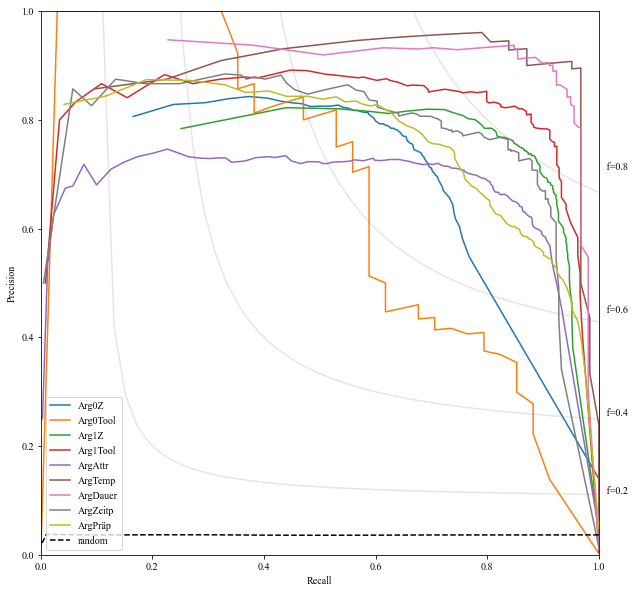

In [807]:
plot_pr_all(thresholds)
#plt.savefig(plot_path+"/both_pr-curve_labels.png")

In [791]:
# Plot f score over threshold to find the best th
def plot_f_curve(df,thresholds,label):
    f = df["f"]
    # plot the roc curve for the model
    plt.plot(thresholds, f, label=label)
    # axis labels

def plot_f_all(thresholds,labels):
    plt.figure(figsize=(5,5))
    for label in labels:
        df_prf_th = prf_th(examples,thresholds,label)
        plot_f_curve(df_prf_th,thresholds,label)
    plt.xlabel('Threshold')
    plt.ylabel('f-score')
    plt.legend()
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])
    plt.savefig(plot_path+"/rel_best-th_labels.png")
    #plt.show()

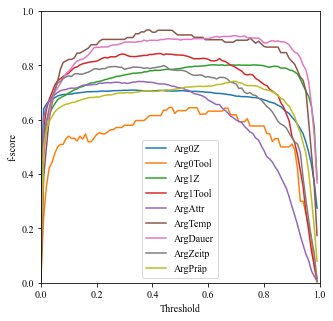

In [792]:
plot_f_all(thresholds,labels)
#plt.savefig(plot_path+"/both_best-th_labels.png")

## Batch Size NER

In [760]:
# Performance of differnelty sized ner train set
columns =["size","th","p","r","f"]

ner_batches = {
    ("0%",0): {
        "Total"   :(0,0,0),
        "Z"       :(0,0,0),
        "PRÄP"    :(0,0,0),
        "V"       :(0,0,0),
        "ATTR"    :(0,0,0),
        "DAUER"   :(0,0,0),
        "ZEITP"   :(0,0,0),
        "TEMP"    :(0,0,0),
        "TOOL"    :(0,0,0)
    },
    ("10%",41): {
        "Total"   :(87.72,   92.70,   90.14),
        "Z"       :(84.35,   95.03,   89.37),
        "PRÄP"    :(90.16,   96.76,   93.34),
        "V"       :(96.57,   98.17,   97.37),
        "ATTR"    :(85.52,   84.36,   84.94),
        "DAUER"   :(67.03,   75.61,   71.06),
        "ZEITP"   :(82.61,   80.66,   81.62),
        "TEMP"    :(41.49,   59.09,   48.75),
        "TOOL"    :(86.42,   77.78,   81.87)
    },
    ("20%",83): {
        "Total"   :(90.54,   94.29,   92.38),
        "Z"       :(91.12,   94.92,   92.98),
        "ATTR"    :(86.40,   86.92,   86.66),
        "V"       :(95.82,   99.00,   97.39),
        "ZEITP"   :(82.10,   88.68,   85.26),
        "PRÄP"    :(93.13,   97.32,   95.18),
        "DAUER"   :(79.52,   80.49,   80.00),
        "TOOL"    :(84.72,   90.37,   87.46),
        "TEMP"    :(40.43,   57.58,   47.50),
    },
    ("30%",124): {
        "Total"   :(91.24,   94.12,   92.66),
        "Z"       :(92.32,   95.14,   93.71),
        "PRÄP"    :(92.44,   98.17,   95.22),
        "V"       :(96.99,   98.06,   97.52),
        "ZEITP"   :(75.49,   90.09,   82.15),
        "ATTR"    :(87.23,   86.32,   86.77),
        "DAUER"   :(84.51,   73.17,   78.43),
        "TOOL"    :(82.89,   91.48,   86.97),
        "TEMP"    :(51.72,   68.18,   58.82),
    },
    ("40%",165): {
        "Total"   :(92.55,   94.36,   93.45),
        "Z"       :(93.74,   95.19,   94.46),
        "ATTR"    :(88.43,   87.37,   87.90),
        "V"       :(97.22,   98.73,   97.97),
        "PRÄP"    :(94.35,   96.48,   95.40),
        "DAUER"   :(80.00,   80.49,   80.24),
        "ZEITP"   :(84.82,   89.62,   87.16),
        "TOOL"    :(84.67,   90.00,   87.25),
        "TEMP"    :(52.38,   66.67,   58.67),
        },
    ("50%",206): {
        "Total"   :(93.39,   95.14,   94.26),
        "Z"       :(94.39,   95.30,   94.84),
        "ATTR"    :(90.20,   88.57,   89.38),
        "V"       :(96.97,   99.17,   98.06),
        "PRÄP"    :(94.29,   97.75,   95.99),
        "ZEITP"   :(87.27,   90.57,   88.89),
        "DAUER"   :(83.13,   84.15,   83.64),
        "TOOL"    :(87.99,   92.22,   90.05),
        "TEMP"    :(61.54,   72.73,   66.67),
        },
    ("60%",248): {
        "Total"   :(92.61,   95.37,   93.97),
        "Z"       :(93.26,   96.15,   94.68),
        "ATTR"    :(88.43,   89.62,   89.02),
        "V"       :(96.45,   99.17,   97.79),
        "PRÄP"    :(94.84,   98.31,   96.54),
        "ZEITP"   :(86.55,   91.04,   88.74),
        "DAUER"   :(81.82,   82.32,   82.07),
        "TOOL"    :(89.14,   88.15,   88.64),
        "TEMP"    :(55.29,   71.21,   62.25),
        },
    ("70%",289): {
        "Total"   :(94.21,   94.92,   94.56),
        "Z"       :(94.90,   95.40,   95.15),
        "ATTR"    :(91.33,   88.72,   90.01),
        "V"       :(97.97,   98.67,   98.32),
        "ZEITP"   :(87.56,   89.62,   88.58),
        "PRÄP"    :(94.91,   97.18,   96.03),
        "DAUER"   :(84.66,   84.15,   84.40),
        "TOOL"    :(89.49,   91.48,   90.48),
        "TEMP"    :(62.82,   74.24,   68.06),
        },
    ("80%",330): {
        "Total"   :(94.18,   95.14,   94.66),
        "Z"       :(95.00,   95.46,   95.23),
        "ATTR"    :(90.95,   89.17,   90.05),
        "V"       :(97.86,   98.67,   98.26),
        "ZEITP"   :(89.30,   90.57,   89.93),
        "PRÄP"    :(95.44,   97.18,   96.30),
        "DAUER"   :(86.50,   85.98,   86.24),
        "TOOL"    :(88.46,   93.70,   91.01),
        "TEMP"    :(56.63,   71.21,   63.09),
        },
    ("90%",372): {
        "Total"   :(94.35,   95.39,   94.87),
        "Z"       :(94.84,   96.31,   95.57),
        "ATTR"    :(92.06,   88.87,   90.44),
        "V"       :(98.02,   98.84,   98.43),
        "ZEITP"   :(85.15,   91.98,   88.44),
        "PRÄP"    :(95.94,   96.48,   96.21),
        "DAUER"   :(86.67,   87.20,   86.93),
        "TOOL"    :(90.48,   91.48,   90.98),
        "TEMP"    :(60.24,   75.76,   67.11),
        },
    ("100%",413): {
        "Total"   :(94.89,   95.39,   95.14),
        "Z"       :(96.02,   95.35,   95.68),
        "ATTR"    :(90.21,   91.43,   90.81),
        "V"       :(98.62,   98.95,   98.78),
        "ZEITP"   :(89.35,   91.04,   90.19),
        "PRÄP"    :(96.61,   96.20,   96.40),
        "DAUER"   :(84.02,   86.59,   85.29),
        "TOOL"    :(90.84,   91.85,   91.34),
        "TEMP"    :(62.35,   80.30,   70.20),
        },
}

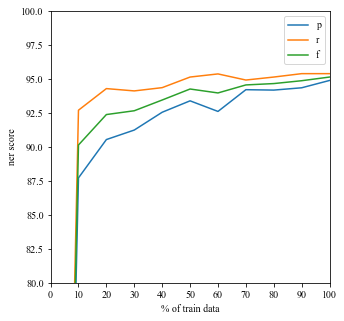

In [761]:
# total batches ner
plt.figure(figsize=(5,5))
plt.xlabel('% of train data')
plt.ylabel('ner score')
axes = plt.gca()
plt.xticks(np.arange(11),np.arange(11)*10)
axes.set_xlim([0,10])
axes.set_ylim([80,100])
plt.plot(pd.DataFrame([ d["Total"] for d in ner_batches.values()], columns = ["p","r","f"]))
plt.legend(["p","r","f"])
#plt.show()
plt.savefig(plot_path+"/ner_batch-size-zoom_overall.png")

,p,r,f
0,0.00,0.00,0.00
1,58.24,71.83,64.33
2,63.81,74.18,68.61
3,65.83,74.96,70.10
4,67.11,75.32,70.98
5,67.87,76.75,72.04
6,68.76,75.02,71.76
7,71.15,75.02,73.03
8,72.83,74.83,73.82
9,73.07,76.54,74.77


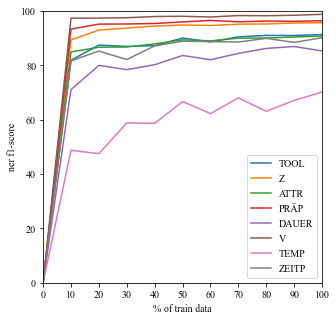

In [763]:
labels = ["TOOL","Z","ATTR","PRÄP","DAUER","V","TEMP","ZEITP"]
# pd.DataFrame([ [ d[label][2] for d in ner_batches.values() ] for label in labels ], columns = [labels])
df_7 = pd.DataFrame([ [d[label][2] for d in ner_batches.values()] for label in labels ]).T
df_7.columns = labels
plt.figure(figsize=(5,5))
plt.xlabel('% of train data')
plt.ylabel('ner f1-score')
axes = plt.gca()
plt.xticks(np.arange(11),np.arange(11)*10)
axes.set_xlim([0,10])
axes.set_ylim([0,100])
plt.plot(df_7)
plt.legend(labels)
#plt.show()
plt.savefig(plot_path+"/ner_batch-size_batches.png")
df

## Batch Size REL

In [369]:
# reassign golds
test_data = "/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/test.spacy"
doc_bin = DocBin(store_user_data=True).from_disk(test_data)
golds = doc_bin.get_docs(rel.vocab)

# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-1/model-best")
# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-2/model-best")
# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-3/model-best")
# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-4/model-best")
# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-5/model-best")
# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-6/model-best")
# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-7/model-best")
# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-8/model-best")
# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-9/model-best")
# rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/02_rel_model/batches/training-10/model-best")

examples = create_examples(False, False, True)

ℹ Detected 156 total instances.
ℹ Detected 35 total instances.
ℹ Detected 180 total instances.
ℹ Detected 37 total instances.
ℹ Detected 220 total instances.
ℹ Detected 101 total instances.
ℹ Detected 95 total instances.
ℹ Detected 158 total instances.
ℹ Detected 173 total instances.
ℹ Detected 127 total instances.
ℹ Detected 59 total instances.
ℹ Detected 126 total instances.
ℹ Detected 29 total instances.
ℹ Detected 161 total instances.
ℹ Detected 113 total instances.
ℹ Detected 89 total instances.
ℹ Detected 70 total instances.
ℹ Detected 115 total instances.
ℹ Detected 198 total instances.
ℹ Detected 155 total instances.
ℹ Detected 193 total instances.
ℹ Detected 154 total instances.
ℹ Detected 107 total instances.
ℹ Detected 101 total instances.
ℹ Detected 87 total instances.
ℹ Detected 164 total instances.
ℹ Detected 164 total instances.
ℹ Detected 108 total instances.
ℹ Detected 78 total instances.
ℹ Detected 129 total instances.
ℹ Detected 135 total instances.
ℹ Detected 115 to

In [358]:
# df_ind_1 = pd.DataFrame([score_relations_ind(examples, 0.3, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_1

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.569714,0.613320,0.590713,1234,932,778,0,2162,0.0
1,Arg0Tool,0.500000,0.117647,0.190476,4,4,30,0,8,0.0
2,Arg1Z,0.619930,0.805723,0.700720,535,328,129,0,858,0.0
3,Arg1Tool,0.679715,0.799163,0.734615,191,90,48,0,278,0.0
4,ArgAttr,0.532374,0.783661,0.634027,518,455,143,0,972,0.0
5,ArgTemp,0.693548,0.693548,0.693548,43,19,19,0,62,0.0
6,ArgDauer,0.724868,0.867089,0.789625,137,52,21,0,188,0.0
7,ArgZeitp,0.578544,0.722488,0.642553,151,110,58,0,260,0.0
8,ArgPräp,0.567437,0.845050,0.678963,589,449,108,0,1037,0.0


In [360]:
# df_ind_2 = pd.DataFrame([score_relations_ind(examples, 0.4, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_2

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.629766,0.681412,0.654571,1371,806,641,0,2174,0.0
1,Arg0Tool,0.750000,0.176471,0.285714,6,2,28,0,8,0.0
2,Arg1Z,0.660645,0.771084,0.711605,512,263,152,0,773,0.0
3,Arg1Tool,0.697674,0.878661,0.777778,210,91,29,0,299,0.0
4,ArgAttr,0.589894,0.759455,0.664021,502,349,159,0,851,0.0
5,ArgTemp,0.846154,0.887097,0.866142,55,10,7,0,65,0.0
6,ArgDauer,0.817647,0.879747,0.847561,139,31,19,0,169,0.0
7,ArgZeitp,0.657480,0.799043,0.721382,167,87,42,0,253,0.0
8,ArgPräp,0.609513,0.790531,0.688320,551,353,146,0,902,0.0


In [362]:
# df_ind_3 = pd.DataFrame([score_relations_ind(examples, 0.4, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_3

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.691933,0.635189,0.662348,1278,569,734,0,1845,0.0
1,Arg0Tool,0.631579,0.352941,0.452830,12,7,22,0,18,0.0
2,Arg1Z,0.687109,0.826807,0.750513,549,250,115,0,796,0.0
3,Arg1Tool,0.728261,0.841004,0.780583,201,75,38,0,274,0.0
4,ArgAttr,0.591224,0.774584,0.670596,512,354,149,0,866,0.0
5,ArgTemp,0.848485,0.903226,0.875000,56,10,6,0,66,0.0
6,ArgDauer,0.809249,0.886076,0.845921,140,33,18,0,169,0.0
7,ArgZeitp,0.656716,0.842105,0.737945,176,92,33,0,267,0.0
8,ArgPräp,0.619565,0.817791,0.705009,570,350,127,0,919,0.0


In [328]:
# df_ind_4 = pd.DataFrame([score_relations_ind(examples, 0.4, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_4

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.659145,0.682406,0.670574,1373,710,639,0,2081,0.0
1,Arg0Tool,0.650000,0.382353,0.481481,13,7,21,0,18,0.0
2,Arg1Z,0.688564,0.852410,0.761777,566,256,98,0,820,0.0
3,Arg1Tool,0.745455,0.857741,0.797665,205,70,34,0,273,0.0
4,ArgAttr,0.624271,0.809380,0.704875,535,322,126,0,857,0.0
5,ArgTemp,0.870968,0.870968,0.870968,54,8,8,0,62,0.0
6,ArgDauer,0.823529,0.886076,0.853659,140,30,18,0,167,0.0
7,ArgZeitp,0.712389,0.770335,0.740230,161,65,48,0,226,0.0
8,ArgPräp,0.650000,0.746055,0.694723,520,280,177,0,799,0.0


In [330]:
# df_ind_5 = pd.DataFrame([score_relations_ind(examples, 0.3, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_5

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.666197,0.705268,0.685176,1419,711,593,0,2124,0.0
1,Arg0Tool,0.520000,0.382353,0.440678,13,12,21,0,24,0.0
2,Arg1Z,0.683841,0.879518,0.769433,584,270,80,0,850,0.0
3,Arg1Tool,0.691558,0.891213,0.778793,213,95,26,0,307,0.0
4,ArgAttr,0.662043,0.794251,0.722146,525,268,136,0,793,0.0
5,ArgTemp,0.808824,0.887097,0.846154,55,13,7,0,67,0.0
6,ArgDauer,0.822857,0.911392,0.864865,144,31,14,0,174,0.0
7,ArgZeitp,0.708333,0.813397,0.757238,170,70,39,0,239,0.0
8,ArgPräp,0.671035,0.734577,0.701370,512,251,185,0,763,0.0


In [343]:
# df_ind_6 = pd.DataFrame([score_relations_ind(examples, 0.6, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_6

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.656832,0.719185,0.686595,1447,756,565,0,2202,0.0
1,Arg0Tool,0.705882,0.352941,0.470588,12,5,22,0,17,0.0
2,Arg1Z,0.751793,0.789157,0.770022,524,173,140,0,696,0.0
3,Arg1Tool,0.739927,0.845188,0.789063,202,71,37,0,273,0.0
4,ArgAttr,0.619154,0.841150,0.713278,556,342,105,0,898,0.0
5,ArgTemp,0.925926,0.806452,0.862069,50,4,12,0,54,0.0
6,ArgDauer,0.902778,0.822785,0.860927,130,14,28,0,144,0.0
7,ArgZeitp,0.726141,0.837321,0.777778,175,66,34,0,241,0.0
8,ArgPräp,0.714063,0.655667,0.683620,457,183,240,0,640,0.0


In [350]:
# df_ind_7 = pd.DataFrame([score_relations_ind(examples, 0.5, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_7

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.718801,0.655567,0.685729,1319,516,693,0,1834,0.0
1,Arg0Tool,0.625000,0.294118,0.400000,10,6,24,0,16,0.0
2,Arg1Z,0.733591,0.858434,0.791117,570,207,94,0,775,0.0
3,Arg1Tool,0.732877,0.895397,0.806026,214,78,25,0,291,0.0
4,ArgAttr,0.661230,0.797277,0.722908,527,270,134,0,797,0.0
5,ArgTemp,0.887097,0.887097,0.887097,55,7,7,0,61,0.0
6,ArgDauer,0.848837,0.924051,0.884848,146,26,12,0,171,0.0
7,ArgZeitp,0.666667,0.870813,0.755187,182,91,27,0,272,0.0
8,ArgPräp,0.688312,0.760402,0.722563,530,240,167,0,770,0.0


In [352]:
# df_ind_8 = pd.DataFrame([score_relations_ind(examples, 0.4, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_8

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.715031,0.680915,0.697556,1370,546,642,0,1915,0.0
1,Arg0Tool,0.619048,0.382353,0.472727,13,8,21,0,21,0.0
2,Arg1Z,0.750336,0.841867,0.793471,559,186,105,0,743,0.0
3,Arg1Tool,0.764286,0.895397,0.824663,214,66,25,0,278,0.0
4,ArgAttr,0.684840,0.779123,0.728946,515,237,146,0,751,0.0
5,ArgTemp,0.892308,0.935484,0.913386,58,7,4,0,64,0.0
6,ArgDauer,0.875000,0.930380,0.901840,147,21,11,0,168,0.0
7,ArgZeitp,0.685039,0.832536,0.751620,174,80,35,0,252,0.0
8,ArgPräp,0.742857,0.708752,0.725404,494,171,203,0,664,0.0


In [354]:
# df_ind_9 = pd.DataFrame([score_relations_ind(examples, 0.4, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_9

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.760482,0.658052,0.705569,1324,417,688,0,1739,0.0
1,Arg0Tool,0.564103,0.647059,0.602740,22,17,12,0,38,0.0
2,Arg1Z,0.704784,0.909639,0.794214,604,253,60,0,855,0.0
3,Arg1Tool,0.734219,0.924686,0.818519,221,80,18,0,300,0.0
4,ArgAttr,0.675406,0.818457,0.740082,541,260,120,0,800,0.0
5,ArgTemp,0.842857,0.951613,0.893939,59,11,3,0,70,0.0
6,ArgDauer,0.853107,0.955696,0.901493,151,26,7,0,176,0.0
7,ArgZeitp,0.706107,0.885167,0.785563,185,77,24,0,260,0.0
8,ArgPräp,0.726508,0.743185,0.734752,518,195,179,0,713,0.0


In [370]:
# df_ind_10 = pd.DataFrame([score_relations_ind(examples, 0.5, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind_10

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.767171,0.655070,0.706702,1318,400,694,0,1718,0.0
1,Arg0Tool,0.730769,0.558824,0.633333,19,7,15,0,26,0.0
2,Arg1Z,0.704626,0.894578,0.788321,594,249,70,0,839,0.0
3,Arg1Tool,0.822581,0.853556,0.837782,204,44,35,0,247,0.0
4,ArgAttr,0.717095,0.717095,0.717095,474,187,187,0,661,0.0
5,ArgTemp,0.904762,0.919355,0.912000,57,6,5,0,63,0.0
6,ArgDauer,0.863905,0.924051,0.892966,146,23,12,0,169,0.0
7,ArgZeitp,0.774648,0.789474,0.781991,165,48,44,0,212,0.0
8,ArgPräp,0.642612,0.804878,0.714650,561,312,136,0,873,0.0


In [764]:
# erste drei nochmal weil th vergessen
df_ind_batches = [
    df_ind_1,
    df_ind_2,
    df_ind_3,
    df_ind_4,
    df_ind_5,
    df_ind_6,
    df_ind_7,
    df_ind_8,
    df_ind_9,
    df_ind_10,
]

In [765]:
cols = df_ind_5["label"]
ibp_list = [[0,0,0,0,0,0,0,0,0]]
for df in df_ind_batches:
    ibp_list.append(list(df["f"]))
df_ibp = pd.DataFrame(ibp_list, columns=cols)
df_ibp.to_pickle(pickle_path+"/rel_batch-size_batches.pkl")
df_ibp

label,Arg0Z,Arg0Tool,Arg1Z,Arg1Tool,ArgAttr,ArgTemp,ArgDauer,ArgZeitp,ArgPräp
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.590713,0.190476,0.700720,0.734615,0.634027,0.693548,0.789625,0.642553,0.678963
2,0.654571,0.285714,0.711605,0.777778,0.664021,0.866142,0.847561,0.721382,0.688320
3,0.662348,0.452830,0.750513,0.780583,0.670596,0.875000,0.845921,0.737945,0.705009
4,0.670574,0.481481,0.761777,0.797665,0.704875,0.870968,0.853659,0.740230,0.694723
5,0.685176,0.440678,0.769433,0.778793,0.722146,0.846154,0.864865,0.757238,0.701370
6,0.686595,0.470588,0.770022,0.789063,0.713278,0.862069,0.860927,0.777778,0.683620
7,0.685729,0.400000,0.791117,0.806026,0.722908,0.887097,0.884848,0.755187,0.722563
8,0.697556,0.472727,0.793471,0.824663,0.728946,0.913386,0.901840,0.751620,0.725404
9,0.705569,0.602740,0.794214,0.818519,0.740082,0.893939,0.901493,0.785563,0.734752


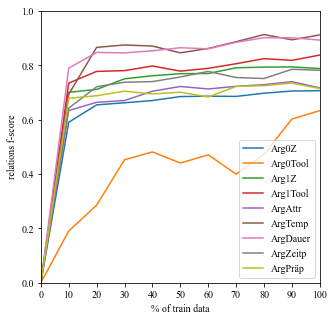

In [767]:
plt.figure(figsize=(5,5))
plt.xlabel('% of train data')
plt.ylabel('relations f-score')
axes = plt.gca()
plt.xticks(np.arange(11),np.arange(11)*10)
axes.set_xlim([0,10])
axes.set_ylim([0,1])
plt.plot(df_ibp)
plt.legend(cols)
# plt.show()
plt.savefig(plot_path+"/rel_batch-size_batches.png")

In [770]:
columns =["size","th","p","r","f"]

samples = [
    (41,  0.30, {'p': '58.24', 'r': '71.83', 'f': '64.33'}),
    (83,  0.40, {'p': '63.81', 'r': '74.18', 'f': '68.61'}),
    (124, 0.40, {'p': '65.83', 'r': '74.96', 'f': '70.10'}),
    (165, 0.40, {'p': '67.11', 'r': '75.32', 'f': '70.98'}),
    (206, 0.30, {'p': '67.87', 'r': '76.75', 'f': '72.04'}),
    (248, 0.60, {'p': '68.76', 'r': '75.02', 'f': '71.76'}),
    (289, 0.50, {'p': '71.15', 'r': '75.02', 'f': '73.03'}),
    (330, 0.40, {'p': '72.83', 'r': '74.83', 'f': '73.82'}),
    (372, 0.40, {'p': '73.07', 'r': '76.54', 'f': '74.77'}),
    (413, 0.50, {'p': '73.49', 'r': '74.70', 'f': '74.09'})
]
spls = [
    (0,0,0,0,0),
    (41,  0.30, 58.24, 71.83, 64.33),
    (83,  0.40, 63.81, 74.18, 68.61),
    (124, 0.40, 65.83, 74.96, 70.10),
    (165, 0.40, 67.11, 75.32, 70.98),
    (206, 0.30, 67.87, 76.75, 72.04),
    (248, 0.60, 68.76, 75.02, 71.76),
    (289, 0.50, 71.15, 75.02, 73.03),
    (330, 0.40, 72.83, 74.83, 73.82),
    (372, 0.40, 73.07, 76.54, 74.77),
    (413, 0.50, 73.49, 74.70, 74.09)
]

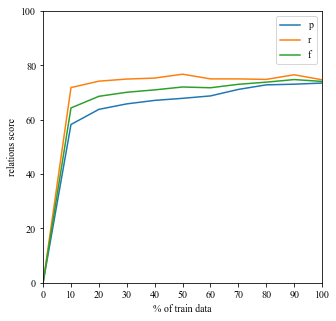

In [771]:
import numpy as np
df = pd.DataFrame([ sample for sample in spls], columns=columns).iloc[:,2:6]
plt.figure(figsize=(5,5))
plt.xlabel('% of train data')
plt.ylabel('relations score')
axes = plt.gca()
plt.xticks(np.arange(11),np.arange(11)*10)
axes.set_xlim([0,10])
axes.set_ylim([0,100])
plt.plot(df)
plt.legend(columns[2:6])
# plt.show()
df
plt.savefig(plot_path+"/rel_batch-size-full_overall.png")

## Token Legth

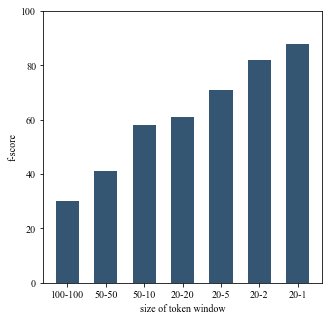

In [837]:
TL_window = ["100-100", "50-50", "50-10", "20-20", "20-5", "20-2", "20-1"]
F =         [ 30,  41, 58, 61, 71, 82, 88 ]
pos_lost =  []
plt.figure(figsize=(5,5))
plt.xlabel('size of token window')
plt.ylabel('f-score')
axes = plt.gca()
#plt.xticks(np.arange(11),np.arange(11)*10)
#axes.set_xlim([205, 20])
axes.set_ylim([0,100])
plt.bar(x = np.arange(7), height=F, tick_label=TL_window, width=0.6, color="#345672")
#plt.legend(["f-score"])
# plt.show()
plt.savefig(plot_path+"/rel_token-length_overall.png")

## Detailled Error Analysis

In [455]:
def error_analysis():
    labels = ["TOOL","Z","ATTR","PRÄP","DAUER","V","TEMP","ZEITP"]
    ed = []
    ignored = 0
    rec=0
    for lbl in labels:
        temp=-2
        err_dict = {}
        
        load_data()
        
        for gold in golds:
            
            pred = ner(gold.text)

            if len(gold) == len(pred):

                gold_tok_labs = [(token, token.ent_type_, token.i) for token in gold]
                pred_tok_labs = [(token, token.ent_type_, token.i) for token in pred]

                for g_tok, g_ent, g_i in gold_tok_labs:
                    # if g_ent != pred_tok_labs[g_i][1]: # If its a mistake
                    if g_ent == lbl: # and the gold entity is equal to current label
                        if g_i != temp+1: # and the token id is not one higher than the one before (same entity)
                            print(g_i, "g:",g_ent, "/ p:",pred_tok_labs[g_i][1], "/", g_tok.text)
                            if pred_tok_labs[g_i][1] in err_dict:
                                err_dict[pred_tok_labs[g_i][1]] +=1
                            else:
                                err_dict[pred_tok_labs[g_i][1]] =1
                        temp=g_i
                rec+=1
            else: 
                ignored+=1
        ed.append(err_dict)
    print(ignored)
    print(ed)
    print(rec)
    return pd.DataFrame(ed, columns=labels)

In [456]:
error_analysis()

94 g: TOOL / p: TOOL / Holzspieße
100 g: TOOL / p: TOOL / Pfanne
17 g: TOOL / p: TOOL / feuerfeste
25 g: TOOL / p: TOOL / Gefrierbeutel
31 g: TOOL / p: TOOL / Schüssel
67 g: TOOL / p: Z / Händen
92 g: TOOL / p: TOOL / Sieb
15 g: TOOL / p: TOOL / Pfanne
65 g: TOOL / p: TOOL / Topf
43 g: TOOL / p: TOOL / Schüssel
66 g: TOOL / p: TOOL / Küchenkrepp
92 g: TOOL / p: TOOL / Schüssel
105 g: TOOL / p: TOOL / Topf
145 g: TOOL / p: TOOL / Topf
3 g: TOOL / p: TOOL / Topf
8 g: TOOL / p: TOOL / Schüssel
133 g: TOOL / p: TOOL / Mozzarellascheibe
139 g: TOOL / p: TOOL / Zahnstochern
161 g: TOOL / p: TOOL / Tellern
2 g: TOOL / p: TOOL / gewässerten
40 g: TOOL / p: TOOL / kalten
10 g: TOOL / p: TOOL / großen
1 g: TOOL / p: TOOL / Backofen
16 g: TOOL / p: TOOL / eckige
24 g: TOOL / p: TOOL / Boden
60 g: TOOL / p: TOOL / Alufolie
67 g: TOOL / p: TOOL / Backofen
40 g: TOOL / p: TOOL / Pfanne
56 g: TOOL / p: TOOL / Pfanne
5 g: TOOL / p: TOOL / Topf
34 g: TOOL / p: TOOL / Pfanne
84 g: TOOL / p: TOOL / flach

0 g: Z / p: Z / Fleisch
22 g: Z / p: Z / Cornflakes
33 g: Z / p: Z / Käse
35 g: Z / p: Z / Öl
37 g: Z / p: Z / Eigelb
39 g: Z / p: Z / Bärlauchpaste
41 g: Z / p: Z / Salz
43 g: Z / p: Z / Pfeffer
54 g: Z / p:  / etwas
59 g: Z / p: Z / Masse
62 g: Z / p: Z / Fleisch
95 g: Z / p:  / mit
2 g: Z / p: Z / Spargel
14 g: Z / p: Z / Salzwasser
17 g: Z / p: Z / Prise
20 g: Z / p: Z / 20
35 g: Z / p: Z / ungeschälten
38 g: Z / p: Z / Wasser
40 g: Z / p: Z / Salz
42 g: Z / p: Z / Kümmel
51 g: Z / p: Z / 25
56 g: Z / p: Z / Mehl
68 g: Z / p: Z / kochenden
96 g: Z / p: Z / Mett
98 g: Z / p: Z / 2
102 g: Z / p: Z / eingeweichten
108 g: Z / p: Z / 24
113 g: Z / p: Z / Salzwasser
123 g: Z / p: Z / 2
127 g: Z / p: Z / Sahne
132 g: Z / p: Z / heiße
140 g: Z / p: Z / Zitronensaft
142 g: Z / p: Z / Salz
144 g: Z / p: Z / frischem
147 g: Z / p: Z / geriebenem
152 g: Z / p: Z / Klöße
155 g: Z / p: Z / Spargel
158 g: Z / p: Z / Sauce
168 g: Z / p: Z / warmen
0 g: Z / p: Z / Zwiebeln
6 g: Z / p: Z / Schweinef

1 g: Z / p: Z / Rigatoni
5 g: Z / p: Z / Wasser
26 g: Z / p: Z / restlichen
32 g: Z / p: Z / wenig
52 g: Z / p: Z / Soße
57 g: Z / p: Z / Nudeln
65 g: Z / p: Z / Soße
1 g: Z / p: Z / Kartoffeln
3 g: Z / p: Z / Salzwasser
7 g: Z / p: Z / Giersch
13 g: Z / p: Z / kochenden
17 g: Z / p: Z / Butter
23 g: Z / p: Z / nunmehr
33 g: Z / p: Z / Eier
45 g: Z / p: Z / Kartoffeln
51 g: Z / p: Z / Kartoffelschnee
59 g: Z / p: Z / Gierschspinat
62 g: Z / p: Z / Ei
1 g: Z / p: Z / Filet
3 g: Z / p: Z / Salz
5 g: Z / p: Z / Pfeffer
7 g: Z / p: Z / Thymian
9 g: Z / p: Z / Rosmarin
11 g: Z / p: Z / Dill
27 g: Z / p: Z / heißem
34 g: Z / p: Z / Butter
36 g: Z / p: Z / Zwiebel
45 g: Z / p: Z / alles
50 g: Z / p: Z / etwas
74 g: Z / p: Z / Brühe
79 g: Z / p: Z / Sahne
87 g: Z / p: Z / Soße
89 g: Z / p: Z / Zitronensaft
91 g: Z / p: Z / Petersilie
94 g: Z / p:  / Wein
0 g: Z / p: Z / Kartoffeln
9 g: Z / p: Z / Salzwasser
15 g: Z / p: Z / Zwiebeln
17 g: Z / p: Z / Knoblauch
24 g: Z / p: Z / Kürbisfruchtfleis

1 g: Z / p: Z / Spinat
10 g: Z / p: Z / Käse
27 g: Z / p: Z / Zwiebel
29 g: Z / p: Z / Spinat
31 g: Z / p: Z / Petersilie
35 g: Z / p: Z / Salz
37 g: Z / p: Z / Pfeffer
39 g: Z / p: Z / Muskatnuss
43 g: Z / p: Z / Butter
51 g: Z / p: Z / Ei
54 g: Z / p: Z / Milch
58 g: Z / p: Z / flüssige
63 g: Z / p: Z / Filoteig
66 g: Z / p: Z / einzelnen
75 g: Z / p: Z / ersten
82 g: Z / p: Z / Teil
89 g: Z / p: Z / Teig
102 g: Z / p: Z / Teig
116 g: Z / p: Z / Spinat-Käse-Mischung
120 g: Z / p: Z / Füllung
123 g: Z / p: Z / überhängenden
129 g: Z / p: Z / restlichen
134 g: Z / p: Z / Teig
142 g: Z / p: TOOL / Form
171 g: Z / p:  / Pastete
0 g: Z / p: Z / Eier
3 g: Z / p: Z / Eiweiß
7 g: Z / p: Z / Eigelb
9 g: Z / p: Z / 2
16 g: Z / p: Z / Milch
21 g: Z / p: Z / Mehl
24 g: Z / p: Z / Backpulver
27 g: Z / p: Z / Prise
37 g: Z / p: Z / Eischnee
40 g: Z / p: Z / Äpfel
55 g: Z / p: Z / Butter
57 g: Z / p: Z / 1
68 g: Z / p: Z / Calvados
73 g: Z / p: Z / Teig
77 g: Z / p: Z / Teig
1 g: Z / p: Z / Wirsing

11 g: Z / p: Z / Kartoffeln
27 g: Z / p: Z / Frühlingszwiebeln
32 g: Z / p: Z / roten
38 g: Z / p: Z / Spitzpaprika
44 g: Z / p: Z / Petersilie
48 g: Z / p: Z / klein
53 g: Z / p: Z / Mais
55 g: Z / p: Z / Kidneybohnen
57 g: Z / p: Z / Paprika
60 g: Z / p: Z / Petersilie
63 g: Z / p: Z / Kartoffeln
69 g: Z / p: Z / Zitronensaft
71 g: Z / p: Z / Olivenöl
73 g: Z / p: Z / Paprikapulver
75 g: Z / p: Z / Pfeffer
77 g: Z / p: Z / Salz
86 g: Z / p: Z / Kartoffeln
90 g: Z / p: Z / alles
0 g: Z / p: Z / Erdnusskerne
5 g: Z / p: Z / Fett
9 g: Z / p: Z / Zwiebeln
13 g: Z / p: Z / Möhren
15 g: Z / p: Z / Sellerie
19 g: Z / p: Z / Wirsing
25 g: Z / p: Z / Zwiebeln
27 g: Z / p: Z / Olivenöl
31 g: Z / p: Z / Möhren
39 g: Z / p: Z / Sellerie
48 g: Z / p: Z / Curry
56 g: Z / p: Z / Gemüsebrühe
66 g: Z / p: Z / Wirsing
85 g: Z / p: Z / Apfel
94 g: Z / p: Z / Apfel
96 g: Z / p: Z / Sahne
98 g: Z / p: Z / Erdnüsse
100 g: Z / p: Z / Gemüse
108 g: Z / p: Z / Cayennepfeffer
110 g: Z / p: Z / Meersalz
112 g:

1 g: Z / p: Z / kalte
9 g: Z / p: Z / Mehl
11 g: Z / p: Z / Ei
13 g: Z / p: Z / etwas
16 g: Z / p: Z / Haselnüssen
40 g: Z / p: Z / Rosenkohl
53 g: Z / p: Z / Zwiebeln
61 g: Z / p: Z / Öl
65 g: Z / p: Z / Zwiebeln
70 g: Z / p: Z / Eier
72 g: Z / p: Z / saure
75 g: Z / p: Z / Senf
79 g: Z / p: Z / Käse
83 g: Z / p: Z / Guss
85 g: Z / p: Z / Salz
87 g: Z / p: Z / Pfeffer
91 g: Z / p: Z / gekühlten
94 g: Z / p: Z / wenig
107 g: Z / p: Z / Quiche-
119 g: Z / p: Z / Teig
130 g: Z / p: Z / Rosenkohl
133 g: Z / p: Z / Zwiebeln
138 g: Z / p: Z / Eiersahne
144 g: Z / p: Z / Haselnüssen
0 g: Z / p: Z / Kartoffeln
9 g: Z / p: Z / Zwischenzeitlich
11 g: Z / p: Z / Spargel
27 g: Z / p: Z / 1
31 g: Z / p: Z / Salz
33 g: Z / p: Z / Zucker
36 g: Z / p: Z / EL
67 g: Z / p:  / Warme
76 g: Z / p: Z / Mayonnaise
78 g: Z / p: Z / Salz
80 g: Z / p: Z / Pfeffer
82 g: Z / p: Z / 1
89 g: Z / p: Z / Soße
92 g: Z / p: Z / Kartoffelscheiben
94 g: Z / p: Z / Spargelenden
106 g: Z / p: Z / Soße
112 g: Z / p: Z / ge

1 g: Z / p: Z / Pellkartoffeln
10 g: Z / p: Z / Zwiebelwürfel
12 g: Z / p: Z / Butter
23 g: Z / p: Z / Buttermilch
35 g: Z / p: Z / braune
39 g: Z / p: Z / Buttermilch
46 g: Z / p: Z / gekochten
58 g: Z / p: Z / Buttermilch
0 g: Z / p: Z / Quark
2 g: Z / p: Z / Zucker
4 g: Z / p: Z / Vanillezucker
6 g: Z / p: Z / Vanillearoma
9 g: Z / p: Z / Eiern
12 g: Z / p: Z / Mehl
23 g: Z / p: Z / Erdbeeren
28 g: Z / p: Z / Vanillezucker
30 g: Z / p: Z / Orangensaft
32 g: Z / p: Z / einige
59 g: Z / p: Z / Butterschmalz
71 g: Z / p: Z / Quarkmasse
96 g: Z / p: Z / Puderzucker
1 g: Z / p: Z / Kartoffeln
8 g: Z / p: Z / Salzheringe
13 g: Z / p: Z / Alle
33 g: Z / p: Z / Mayonnaise
36 g: Z / p: Z / Öl
38 g: Z / p: Z / Essig
41 g: Z / p: Z / Eigelb
46 g: Z / p: Z / Salat
50 g: Z / p: Z / Pfeffer
52 g: Z / p: Z / Salz
18 g: Z / p: Z / Öl
28 g: Z / p: Z / Geschnetzelte
31 g: Z / p: Z / Mehl
43 g: Z / p: Z / Fleisch
52 g: Z / p: Z / gehackten
58 g: Z / p: Z / Erdnüsse
62 g: Z / p: Z / Zwiebeln
67 g: Z / 

5 g: ATTR / p: ATTR / in
25 g: ATTR / p: ATTR / darin
57 g: ATTR / p: ATTR / darin
62 g: ATTR / p: ATTR / darüber
70 g: ATTR / p: ATTR / unter
11 g: ATTR / p: ATTR / in
20 g: ATTR / p: ATTR / in
38 g: ATTR / p: ATTR / in
45 g: ATTR / p: ATTR / super
103 g: ATTR / p: ATTR / gut
2 g: ATTR / p: ATTR / nach
34 g: ATTR / p: ATTR / feincremig
53 g: ATTR / p: ATTR / vorsichtig
60 g: ATTR / p:  / noch
8 g: ATTR / p: ATTR / klein
26 g: ATTR / p: ATTR / kurz
63 g: ATTR / p: ATTR / darüber
12 g: ATTR / p: ATTR / gut
29 g: ATTR / p: ATTR / von
38 g: ATTR / p: Z / in
46 g: ATTR / p: DAUER / kurz
3 g: ATTR / p: ATTR / bei
20 g: ATTR / p: ATTR / fein
25 g: ATTR / p: ATTR / in
39 g: ATTR / p: ATTR / darin
67 g: ATTR / p: ATTR / zugedeckt
78 g: ATTR / p: ATTR / in
62 g: ATTR / p: ATTR / darin
76 g: ATTR / p: ATTR / unter
7 g: ATTR / p: ATTR / sehr
52 g: ATTR / p: ATTR / unter
57 g: ATTR / p: ATTR / ganz
117 g: ATTR / p: ATTR / heiß
53 g: ATTR / p: ATTR / N
68 g: ATTR / p: ATTR / zugedeckt
103 g: ATTR /

11 g: ATTR / p: ATTR / krümelig
42 g: ATTR / p: ATTR / nebeneinander
61 g: ATTR / p: ATTR / unter
68 g: ATTR / p: ATTR / gut
92 g: ATTR / p: ATTR / darüber
8 g: ATTR / p: ATTR / klein
15 g: ATTR / p: ATTR / von
2 g: ATTR / p: ATTR / grob
6 g: ATTR / p: ATTR / in
12 g: ATTR / p: ATTR / klein
19 g: ATTR / p: ATTR / glasig
27 g: ATTR / p: ATTR / goldbraun
60 g: ATTR / p: ATTR / goldbraun
3 g: ATTR / p: ATTR / trocken
14 g: ATTR / p: ATTR / darin
3 g: ATTR / p: ATTR / in
28 g: ATTR / p: ATTR / Zugedeckt
33 g: ATTR / p: ATTR / kalt
48 g: ATTR / p: ATTR / gut
56 g: ATTR / p: ATTR / in
66 g: ATTR / p: ATTR / darin
96 g: ATTR / p: PRÄP / zu
134 g: ATTR / p: ATTR / darauf
139 g: ATTR / p: ATTR / darüber
161 g: ATTR / p: ATTR / goldbraun
1 g: ATTR / p: ATTR / gar
6 g: ATTR / p: ATTR / warm
69 g: ATTR / p: ATTR / in
103 g: ATTR / p: ATTR / vorsichtig
116 g: ATTR / p: ATTR / vorsichtig
7 g: ATTR / p: ATTR / fein
22 g: ATTR / p: ATTR / darin
40 g: ATTR / p: ATTR / Eiskalt
43 g: ATTR / p: ATTR / gut

3 g: PRÄP / p: PRÄP / in
14 g: PRÄP / p: PRÄP / in
16 g: PRÄP / p: PRÄP / mit
51 g: PRÄP / p: PRÄP / in
56 g: PRÄP / p: PRÄP / Im
75 g: PRÄP / p: PRÄP / Mit
87 g: PRÄP / p: PRÄP / in
107 g: PRÄP / p: PRÄP / auf
9 g: PRÄP / p: PRÄP / mit
12 g: PRÄP / p: PRÄP / in
16 g: PRÄP / p: PRÄP / in
73 g: PRÄP / p: PRÄP / zum
82 g: PRÄP / p: PRÄP / mit
127 g: PRÄP / p: PRÄP / Mit
139 g: PRÄP / p: PRÄP / in
15 g: PRÄP / p: PRÄP / mit
51 g: PRÄP / p: PRÄP / im
67 g: PRÄP / p: PRÄP / Mit
89 g: PRÄP / p: PRÄP / Mit
106 g: PRÄP / p: PRÄP / in
128 g: PRÄP / p: PRÄP / mit
4 g: PRÄP / p: PRÄP / in
51 g: PRÄP / p: PRÄP / im
53 g: PRÄP / p: PRÄP / mit
67 g: PRÄP / p: PRÄP / im
77 g: PRÄP / p: PRÄP / zu
96 g: PRÄP / p: PRÄP / in
140 g: PRÄP / p:  / mit
4 g: PRÄP / p: PRÄP / im
28 g: PRÄP / p: PRÄP / in
31 g: PRÄP / p: PRÄP / mit
63 g: PRÄP / p: PRÄP / mit
2 g: PRÄP / p: PRÄP / in
11 g: PRÄP / p: PRÄP / über
18 g: PRÄP / p: PRÄP / im
52 g: PRÄP / p: PRÄP / auf
61 g: PRÄP / p: PRÄP / mit
2 g: PRÄP / p: PRÄP / 

16 g: PRÄP / p: PRÄP / mit
54 g: PRÄP / p: PRÄP / mit
62 g: PRÄP / p: PRÄP / in
67 g: PRÄP / p: PRÄP / durch
73 g: PRÄP / p: PRÄP / in
95 g: PRÄP / p: PRÄP / in
109 g: PRÄP / p: PRÄP / in
123 g: PRÄP / p: PRÄP / mittels
136 g: PRÄP / p: PRÄP / Mit
139 g: PRÄP / p: PRÄP / aus
149 g: PRÄP / p: PRÄP / mit
156 g: PRÄP / p: PRÄP / mit
39 g: PRÄP / p: PRÄP / in
59 g: PRÄP / p: PRÄP / über
69 g: PRÄP / p: PRÄP / mit
106 g: PRÄP / p: PRÄP / mit
115 g: PRÄP / p: PRÄP / mit
120 g: PRÄP / p: PRÄP / auf
124 g: PRÄP / p: PRÄP / mit
0 g: PRÄP / p: PRÄP / Aus
48 g: PRÄP / p: PRÄP / in
70 g: PRÄP / p: PRÄP / in
75 g: PRÄP / p: PRÄP / Im
81 g: PRÄP / p: PRÄP / auf
6 g: PRÄP / p: PRÄP / Mit
26 g: PRÄP / p: PRÄP / im
42 g: PRÄP / p: PRÄP / Mit
64 g: PRÄP / p: PRÄP / auf
94 g: PRÄP / p: PRÄP / auf
99 g: PRÄP / p: PRÄP / Mit
107 g: PRÄP / p: PRÄP / mit
16 g: PRÄP / p: PRÄP / auf
24 g: PRÄP / p: PRÄP / mit
35 g: PRÄP / p: PRÄP / auf
40 g: PRÄP / p: PRÄP / Mit
46 g: PRÄP / p: PRÄP / In
23 g: PRÄP / p: PRÄP /

77 g: DAUER / p: TEMP / ca.
79 g: DAUER / p: DAUER / etwa
114 g: DAUER / p: DAUER / 5
73 g: DAUER / p: DAUER / 40
125 g: DAUER / p: DAUER / ca.
51 g: DAUER / p: DAUER / kurz
29 g: DAUER / p: DAUER / ca.
76 g: DAUER / p: DAUER / ca.
90 g: DAUER / p: DAUER / weitere
129 g: DAUER / p: DAUER / etwa
135 g: DAUER / p: DAUER / Ca
15 g: DAUER / p: DAUER / einige
48 g: DAUER / p: DAUER / Ca
61 g: DAUER / p: DAUER / kurz
127 g: DAUER / p: DAUER / ca.
148 g: DAUER / p: DAUER / ca.
43 g: DAUER / p: DAUER / 20
57 g: DAUER / p: DAUER / weitere
50 g: DAUER / p: DAUER / 60
28 g: DAUER / p: DAUER / kurz
42 g: DAUER / p: DAUER / etwa
50 g: DAUER / p: DAUER / bis
63 g: DAUER / p: DAUER / ca.
40 g: DAUER / p: DAUER / das
109 g: DAUER / p: DAUER / ca.
5 g: DAUER / p: DAUER / ca.
99 g: DAUER / p: DAUER / kurz
101 g: DAUER / p: DAUER / etwa
27 g: DAUER / p: DAUER / 10
76 g: DAUER / p: DAUER / ca.
109 g: DAUER / p: DAUER / 2
69 g: DAUER / p: DAUER / ca.
38 g: DAUER / p: DAUER / bis
19 g: DAUER / p: DAUER / ca

2 g: V / p: V / putzen
7 g: V / p: V / würfeln
9 g: V / p: V / beiseitelegen
15 g: V / p: V / würfeln
19 g: V / p: V / kochen
38 g: V / p: V / abschütten
45 g: V / p: V / anbraten
55 g: V / p: V / würzen
66 g: V / p: V / zugeben
82 g: V / p: V / braten
88 g: V / p: V / dazugeben
94 g: V / p: V / braten
106 g: V / p: V / dazugeben
108 g: V / p: V / umrühren
125 g: V / p: V / würzen
133 g: V / p: V / hinzugeben
140 g: V / p: V / kochen
144 g: V / p: V / servieren
2 g: V / p: V / abbrausen
4 g: V / p: V / vierteln
9 g: V / p: V / geben
13 g: V / p: V / abbrausen
19 g: V / p: V / legen
24 g: V / p: V / zupfen
28 g: V / p: V / durchpressen
36 g: V / p: V / geben
38 g: V / p: V / Salzen
46 g: V / p: V / vermischen
52 g: V / p: V / ziehen
59 g: V / p: V / kochen
62 g: V / p: V / abschrecken
67 g: V / p: V / geben
71 g: V / p: V / abziehen
73 g: V / p: V / würfeln
80 g: V / p: V / anbraten
85 g: V / p: V / dazugeben
91 g: V / p: V / auftauen
102 g: V / p: V / würzen
107 g: V / p: V / tupfen
11

4 g: V / p: V / einweichen
13 g: V / p: V / rösten
44 g: V / p: V / verkneten
46 g: V / p: V / Abschmecken
50 g: V / p: V / nachwürzen
78 g: V / p: V / zugeben
89 g: V / p: V / formen
101 g: V / p: V / anbraten
103 g: V / p: V / durchgaren
9 g: V / p: V / kochen
12 g: V / p: V / erkalten
35 g: V / p: V / schälen
39 g: V / p: V / befreien
43 g: V / p: V / schneiden
57 g: V / p: V / kochen
63 g: V / p: V / abtropfen
69 g: V / p: V / trennen
80 g: V / p: V / verrühren
86 g: V / p: V / heben
92 g: V / p: V / herstellen
98 g: V / p: V / heben
107 g: V / p: V / ausstreuen
113 g: V / p: V / einfüllen
118 g: V / p: V / schichten
125 g: V / p: V / streichen
137 g: V / p: V / backen
8 g: V / p: V / zerlassen
19 g: V / p: V / dünsten
23 g: V / p: V / bestäuben
27 g: V / p: V / nehmen
32 g: V / p: V / zugeben
38 g: V / p: V / rühren
49 g: V / p: V / stellen
52 g: V / p: V / minimieren
56 g: V / p: V / auffüllen
58 g: V / p: V / aufkochen
63 g: V / p: V / rühren
73 g: V / p: V / zugeben
75 g: V / p

1 g: V / p: V / schmelzen
9 g: V / p: V / anschwitzen
15 g: V / p: V / ablöschen
29 g: V / p: V / zufügen
33 g: V / p: V / aufkochen
41 g: V / p: V / köcheln
48 g: V / p: V / schneiden
56 g: V / p: V / schneiden
59 g: V / p: V / vierteln
62 g: V / p: V / erhitzen
68 g: V / p: V / anbraten
70 g: V / p: V / würzen
72 g: V / p: V / herausnehmen
81 g: V / p: V / würzen
84 g: V / p: V / herausnehmen
87 g: V / p: V / halbieren
92 g: V / p: V / ausreiben
99 g: V / p: V / geben
105 g: V / p: V / hineinlegen
113 g: V / p: V / einschichten
121 g: V / p: V / garnieren
125 g: V / p: V / reiben
129 g: V / p: V / mischen
134 g: V / p: V / bestreuen
147 g: V / p: V / backen
10 g: V / p: V / einweichen
26 g: V / p: V / kochen
36 g: V / p: V / herausnehmen
41 g: V / p: V / schälen
43 g: V / p: V / vierteln
47 g: V / p: V / schneiden
51 g: V / p: V / schälen
53 g: V / p: V / feinhacken
65 g: V / p: V / erhitzen
72 g: V / p: V / braten
76 g: V / p: V / vierteln
78 g: V / p: V / entkernen
80 g: V / p: V /

4 g: V / p: V / beträufeln
18 g: V / p: V / mischen
22 g: V / p: V / schälen
30 g: V / p: V / filetieren
35 g: V / p: V / zerkleinern
39 g: V / p: V / schälen
42 g: V / p: V / achteln
53 g: V / p: V / anbraten
62 g: V / p: V / dazugeben
66 g: V / p: V / mitbraten
68 g: V / p: V / Salzen
70 g: V / p: Z / Pfeffern
77 g: V / p: V / ablöschen
102 g: V / p: V / dazugeben
106 g: V / p: V / garen
114 g: V / p: V / umrühren
122 g: V / p: V / geben
125 g: V / p: V / durchmischen
129 g: V / p: V / abschmecken
2 g: V / p: V / vorheizen
8 g: V / p: V / aufwärmen
24 g: V / p: V / erhitzen
31 g: V / p: V / anbraten
34 g: V / p: V / herausnehmen
36 g: V / p: V / salzen
38 g: V / p: V / pfeffern
41 g: V / p: V / hacken
45 g: V / p: V / andünsten
50 g: V / p: V / schneiden
52 g: V / p: V / zugeben
56 g: V / p: V / bestäuben
59 g: V / p: V / umrühren
64 g: V / p: V / ablöschen
69 g: V / p: V / zugeben
76 g: V / p: V / köcheln
81 g: V / p: V / zugeben
83 g: V / p: V / wärmen
86 g: V / p: V / unterheben
9

1 g: V / p: V / schälen
5 g: V / p: V / schneiden
18 g: V / p: V / anrösten
34 g: V / p: V / dazugeben
36 g: V / p: V / mitbraten
55 g: V / p: V / zugeben
58 g: V / p: V / Rühren
71 g: V / p: V / dazugeben
74 g: V / p: V / Rühren
78 g: V / p: V / kochen
89 g: V / p: V / dazugeben
92 g: V / p: V / mischen
98 g: V / p: V / abschmecken
107 g: V / p: V / köcheln
124 g: V / p: V / unterheben
126 g: V / p: V / servieren
11 g: V / p: V / aufsetzen
16 g: V / p: V / erhitzen
20 g: V / p: V / abseihen
28 g: V / p: V / kommen
43 g: V / p: V / hineingeben
46 g: V / p: V / werden
53 g: V / p: V / hineingeben
63 g: V / p: V / abtropfen
112 g: V / p: V / geben
117 g: V / p: V / vermischen
141 g: V / p: V / gelassen
176 g: V / p: V / anrichten
182 g: V / p: V / zugeben
195 g: V / p: V / verteilen
6 g: V / p: V / beträufeln
8 g: V / p: V / durchmischen
15 g: V / p: V / reiben
23 g: V / p: V / durchmischen
31 g: V / p: V / würzen
33 g: V / p: V / verquirlen
38 g: V / p: V / flachklopfen
41 g: V / p: V /

5 g: V / p: V / verrühren
14 g: V / p: V / dazumischen
19 g: V / p: V / ruhen
25 g: V / p: V / waschen
27 g: V / p: V / schälen
32 g: V / p: V / schneiden
39 g: V / p: V / schmelzen
55 g: V / p: V / dazugeben
61 g: V / p: V / verteilen
69 g: V / p: V / backen
74 g: V / p: V / genießen
5 g: V / p: V / schneiden
10 g: V / p:  / würfeln
18 g: V / p: V / erhitzen
23 g: V / p: V / braten
26 g: V / p: V / zugeben
30 g: V / p: V / bräunen
33 g: V / p: V / zufügen
39 g: V / p: V / Durchschmoren
41 g: V / p: V / salzen
43 g: V / p: V / pfeffern
46 g: V / p: V / schnetzeln
52 g: V / p: V / braten
54 g: V / p: V / Salzen
56 g: V / p: V / pfeffern
61 g: V / p: V / mischen
66 g: V / p: V / servieren
8 g: V / p: V / schneiden
14 g: V / p: V / verteilen
22 g: V / p: V / schneiden
27 g: V / p: V / verteilen
33 g: V / p: V / bröseln
35 g: V / p: V / salzen
37 g: V / p: V / pfeffern
42 g: V / p: V / begießen
53 g: V / p: V / backen
5 g: V / p: V / geben
7 g: V / p: V / mixen
27 g: V / p: V / erhitzen
33

7 g: ZEITP / p: ZEITP / anschließend
86 g: ZEITP / p: ZEITP / Dann
102 g: ZEITP / p: ZEITP / Nun
62 g: ZEITP / p: ZEITP / zum
15 g: ZEITP / p: ZEITP / Inzwischen
30 g: ZEITP / p: ZEITP / dann
66 g: ZEITP / p: ZEITP / Sofort
36 g: ZEITP / p: ZEITP / In
47 g: ZEITP / p: ZEITP / anschließend
122 g: ZEITP / p: ZEITP / dabei
128 g: ZEITP / p: ZEITP / Nun
164 g: ZEITP / p: ZEITP / Sofort
109 g: ZEITP / p: ZEITP / Zum
134 g: ZEITP / p: ZEITP / Vor
16 g: ZEITP / p: ZEITP / Dann
63 g: ZEITP / p: ZEITP / Jetzt
70 g: ZEITP / p: ZEITP / dann
80 g: ZEITP / p: ZEITP / Dann
64 g: ZEITP / p: ZEITP / Dann
73 g: ZEITP / p: ZEITP / Gelegentlich
0 g: ZEITP / p: ZEITP / Zuerst
13 g: ZEITP / p: ZEITP / Nun
22 g: ZEITP / p: ZEITP / Sollte
34 g: ZEITP / p: ZEITP / Sobald
49 g: ZEITP / p: ZEITP / Nun
55 g: ZEITP / p: ZEITP / Wenn
99 g: ZEITP / p: ATTR / rasch
114 g: ZEITP / p: ZEITP / Dabei
124 g: ZEITP / p: ZEITP / dann
14 g: ZEITP / p: ZEITP / anschließend
105 g: ZEITP / p: ZEITP / Sofort
8 g: ZEITP / p: ZEI

,TOOL,Z,ATTR,PRÄP,DAUER,V,TEMP,ZEITP
0,235.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN
1,6.0,1882.0,2.0,NaN,NaN,NaN,5.0,NaN
2,NaN,1.0,555.0,3.0,3.0,NaN,1.0,1.0
3,NaN,NaN,2.0,703.0,NaN,NaN,NaN,1.0
4,NaN,NaN,2.0,NaN,178.0,NaN,2.0,1.0
5,NaN,1.0,NaN,NaN,NaN,1803.0,1.0,NaN
6,NaN,NaN,NaN,2.0,NaN,NaN,60.0,NaN
7,NaN,NaN,1.0,NaN,1.0,NaN,NaN,187.0


In [443]:
cols = ["TOOL","Z","ATTR","PRÄP","DAUER","V","TEMP","ZEITP",""]
rows = ["TOOL","Z","ATTR","PRÄP","DAUER","V","TEMP","ZEITP"]

In [444]:
# ner.evaluate(examples)
# from spacy.scorer import Scorer
# scorer = Scorer()
# scorer.score(examples)

In [447]:
ed = [{'Z': 3, 'ATTR': 2, '': 2}, 
      {'': 25, 'ATTR': 2, 'TOOL': 6, 'TEMP': 5}, 
      {'PRÄP': 3, '': 16, 'DAUER': 3, 'Z': 1, 'ZEITP': 1, 'TEMP': 1}, 
      {'ATTR': 2, '': 7, 'ZEITP': 1}, 
      {'TEMP': 2, '': 4, 'ZEITP': 1, 'ATTR': 2}, 
      {'': 19, 'TEMP': 1, 'Z': 1}, 
      {'': 2, 'PRÄP': 2}, 
      {'DAUER': 2, 'ATTR': 3, '': 5}]
ed = pd.DataFrame(ed, columns=cols,index=rows)

In [453]:
cols = ["TOOL","Z","ATTR","PRÄP","DAUER","V","TEMP","ZEITP","None"]
ed.columns = cols
ed= ed.fillna(0)
ed

,TOOL,Z,ATTR,PRÄP,DAUER,V,TEMP,ZEITP,None
TOOL,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2
Z,6.0,0.0,2.0,0.0,0.0,0.0,5.0,0.0,25
ATTR,0.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,16
PRÄP,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,7
DAUER,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,4
V,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,19
TEMP,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2
ZEITP,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,5


In [459]:
ed = [{'TOOL': 235, 'Z': 3, 'ATTR': 1, '': 2}, {'Z': 1882, '': 23, 'ATTR': 2, 'TOOL': 6, 'TEMP': 5}, {'ATTR': 555, 'PRÄP': 3, '': 15, 'DAUER': 3, 'Z': 1, 'ZEITP': 1, 'TEMP': 1}, {'PRÄP': 703, 'ATTR': 2, '': 7, 'ZEITP': 1}, {'DAUER': 178, 'TEMP': 2, '': 2, 'ZEITP': 1, 'ATTR': 2}, {'V': 1803, '': 19, 'TEMP': 1, 'Z': 1}, {'TEMP': 60, '': 1, 'PRÄP': 2}, {'ZEITP': 187, 'DAUER': 1, '': 5, 'ATTR': 1}]
cols = ["TOOL","Z","ATTR","PRÄP","DAUER","V","TEMP","ZEITP",""]
rows = ["TOOL","Z","ATTR","PRÄP","DAUER","V","TEMP","ZEITP"]
ed = pd.DataFrame(ed, columns=cols,index=rows)

In [460]:
cols = ["TOOL","Z","ATTR","PRÄP","DAUER","V","TEMP","ZEITP","None"]
ed.columns = cols
ed= ed.fillna(0)
ed

,TOOL,Z,ATTR,PRÄP,DAUER,V,TEMP,ZEITP,None
TOOL,235.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2
Z,6.0,1882.0,2.0,0.0,0.0,0.0,5.0,0.0,23
ATTR,0.0,1.0,555.0,3.0,3.0,0.0,1.0,1.0,15
PRÄP,0.0,0.0,2.0,703.0,0.0,0.0,0.0,1.0,7
DAUER,0.0,0.0,2.0,0.0,178.0,0.0,2.0,1.0,2
V,0.0,1.0,0.0,0.0,0.0,1803.0,1.0,0.0,19
TEMP,0.0,0.0,0.0,2.0,0.0,0.0,60.0,0.0,1
ZEITP,0.0,0.0,1.0,0.0,1.0,0.0,0.0,187.0,5
